original image


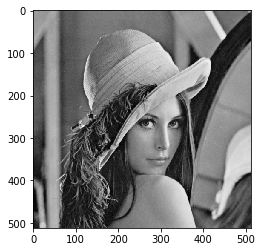

binarized image


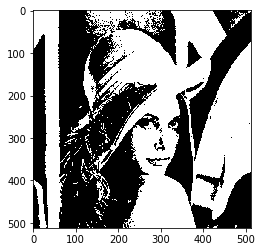

image histogram


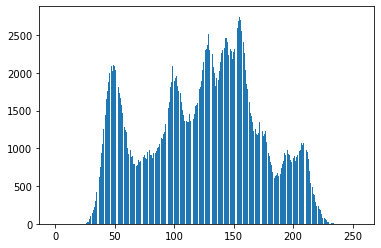

cc area:  [2688, 2683, 1420, 1678, 2351]
bounding box coordinate
    up   down   left  right cent_i cent_j
     0    511      0     87    229     42
     0    511    127    511    245    344
    94    237    118    157    175    132
   237    287     89    139    264    116
   399    511      0     31    457     17

connected components with color segmentations


NameError: name 'CV2_RGB2BGR' is not defined

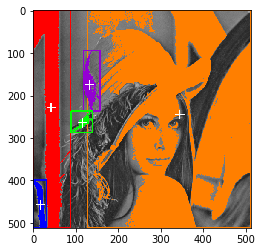

In [7]:
#!/usr/bin/env python
# coding: utf-8
# NTU CSIE, Computer Vision HW2, R08922024, Alfons Hwu

import cv2
import math, sys
import matplotlib.pyplot as plt

'''notes
savefig sould be done before show
see: https://blog.csdn.net/u010099080/article/details/52912439
'''
########## IO and the first 2 problems ##############
####### hist ########
def img_hist(img_in):
    hist = [0 for i in range(256)]

    row, col= img_in.shape
    for i in range(0, row):
        for j in range(0, col):
            hist[img_in[i, j]] += 1

    print('image histogram')
    plt.bar(range(0, 256), hist)
    plt.savefig('histogram.png')
    plt.show()
    return 0

####### binarize ######
def img_binarize(img_in):
    return (img_in > 0x7f) * 0xff

########## driver functions the first 2 problems ####
img = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
print('original image')
plt.imshow(img, cmap = 'gray')
plt.show()

img_binarized = img_binarize(img)
print('binarized image')
plt.imshow(img_binarized, cmap = 'gray')
plt.savefig('lena_binarized.png', cmap = 'gray')
plt.show()

img_hist(img)

############ the 3rd problem ########################
op_cnt = 0
parent_label = []
cc_img = (img_binarized == 0xff) * 1
rgb_img = cv2.imread('lena.bmp', cv2.IMREAD_COLOR)

###### disjoint set union and find algorithm ###
def union_find(label):
    original_label = label
    cnt = 0
    row, col = cc_img.shape
    global op_cnt
    while label != parent_label[label] and cnt < row * col:
        op_cnt += 1
        label = parent_label[parent_label[label]]
        cnt += 1

    parent_label[original_label] = label # path compression to avoid TLE
    return label

############### draw the result rectangle ######
def draw_rect(u, d, l, r, color):
    cv2.rectangle(rgb_img, (l, u), (r, d), color, 2)

############### draw the result centroid #######
SHIFT = 10
def draw_cent(cen_i, cen_j, color):
    cv2.line(rgb_img, (cen_j - SHIFT, cen_i), (cen_j + SHIFT, cen_i), color, 2)
    cv2.line(rgb_img, (cen_j, cen_i - SHIFT), (cen_j, cen_i + SHIFT), color, 2)

############### CC main function ###############
LABEL_THRESHOLD = 500
def connected_components():
    global op_cnt
    
    # set parent label
    row, col = cc_img.shape
    for i in range(row * col):
        parent_label.append(i)

    # do connected components
    label = 2
    for i in range(row):
        for j in range(col):
            ok1 = 0
            ok2 = 0
            op_cnt += 1
            if cc_img[i, j] == 1:
                if j - 1 >= 0 and cc_img[i, j - 1] > 1: # left has already labeled
                    cc_img[i, j] = union_find(cc_img[i, j - 1])
                    ok1 = 1

                if i - 1 >= 0 and cc_img[i - 1, j] > 1: # up has already labeled
                    if ok1: # set the connected component to make left = up as the same group
                        parent_label[cc_img[i, j]] = union_find(cc_img[i - 1, j])
                    else:
                        cc_img[i, j] = cc_img[i - 1, j]

                    ok2 = 1
                    
                if ok2 == 0 and ok1 == 0:
                    cc_img[i, j] = label
                    label += 1

    # union and find merging
    for i in range(row):
        for j in range(col):
            op_cnt += 1
            if cc_img[i, j] > 1:
                cc_img[i, j] = union_find(cc_img[i, j])

    mymap = [0 for i in range (row * col)]

    # statistical data for label threshold > 500
    for i in range(0, row):
        for j in range(0, col):
            mymap[cc_img[i, j]] += 1

    cc_pos = {}
    cc_value = []
    for i in range(0, row):
        for j in range(0, col):
            if cc_img[i, j] and cc_img[i, j] not in cc_value and mymap[cc_img[i, j]] > LABEL_THRESHOLD:
                cc_value.append(cc_img[i, j])
    
    print('cc area: ', cc_value)
    for i in cc_value:
        cc_pos[i] = []
    
    # rainbow colors for different image segmentations
    rainbow = [(255, 0, 0), (255, 127, 0), (148, 0, 211), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    rainbow_idx = 0
    
    # change the rgb image to black and white
    for i in range(0, row):
        for j in range(0, col):
            if cc_img[i, j] and mymap[cc_img[i, j]] > LABEL_THRESHOLD:
                cc_pos[cc_img[i, j]].append((i, j))
                if cc_img[i, j]:
                    rgb_img[i, j] = (255, 255, 255) 
                else:
                    rgb_img[i, j] = (0, 0, 0) 
                    
    # draw the rectangles and centroid                
    print('bounding box coordinate')
    print('%6s %6s %6s %6s %6s %6s' %('up', 'down', 'left', 'right', 'cent_i', 'cent_j'))
    for each_cc_value in cc_value:
        u = min(cc_pos[each_cc_value], key = lambda i : i [0])[0]
        d = max(cc_pos[each_cc_value], key = lambda i : i [0])[0]
        l = min(cc_pos[each_cc_value], key = lambda i : i [1])[1]
        r = max(cc_pos[each_cc_value], key = lambda i : i [1])[1]
        
        cen_i, cen_j = [sum(i) / len(i) for i in zip(*cc_pos[each_cc_value])]
        cen_i = int(cen_i)
        cen_j = int(cen_j)
        
        print('%6d %6d %6d %6d %6d %6d' %(u, d, l, r, cen_i, cen_j))
        
        for (i, j) in cc_pos[each_cc_value]:
            rgb_img[i, j] = rainbow[rainbow_idx % 6]
            
        draw_rect(u, d, l, r, rainbow[rainbow_idx % 6])
        draw_cent(cen_i, cen_j, (255, 255, 255))
        rainbow_idx += 1
        
########## driver functions the 3rd problem ####### 
connected_components()
print('\nconnected components with color segmentations')
plt.imshow(rgb_img)
cv2.imwrite('lena_connected_components.png', cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR))
#plt.savefig('lena_connected_components.png', cmap = 'gray')
plt.show()
print('iterative operations count: ', op_cnt)